# Tutorial on ensemble history matching and optimisation

Copyright Patrick N. Raanes, NORCE, 2020.

This (Jupyter/Python) notebook presents
a tutorial on history matching (HM) using ensemble methods.

This is a work in progress.
Details may be lacking.
Don't hesitate to send me an email with any questions you have.

Install Anaconda.

Open the Anaconda terminal(Anaconda Prompt) and run the following commands:

>conda create --yes --name my-env python=3.7

>conda activate my-env

Keep using the same terminal for the commands below.

Download and unzip (or git clone) HistoryMatching repository

In Anaconda terminal use:
> cd -path/to (folder
command to change the directory to location you saved the "HistoryMatching repository").

>pip install -r path/to/requirements.txt

Launch the "notebook server" by executing: 
>jupyter notebook

## Jupyter notebooks
the format used for these tutorials.
Notebooks combine **cells** of code (Python) with cells of text (markdown).
The exercises in these tutorials only require light Python experience.
For example, edit the cell below (double-click it),
insert your name,
and run it (press "Run" in the toolbar).

You will likely be more efficient if you know these
**keyboard shortcuts** to interact with cells:

| Navigate                      |    | Edit              |    | Exit           |    | Run                              |    | Run & go to next                  |
| -------------                 | -- | ----------------- | -- | --------       | -- | -------                          | -- | -----------------                 |
| <kbd>↓</kbd> and <kbd>↑</kbd> |    | <kbd>Enter</kbd>  |    | <kbd>Esc</kbd> |    | <kbd>Ctrl</kbd>+<kbd>Enter</kbd> |    | <kbd>Shift</kbd>+<kbd>Enter</kbd> |

When you open a notebook it starts a **session (kernel/runtime)**
of Python in the background.
All of the Python code cells (in a given notebook) are connected
(they use the same Python kernel and thus share variables, functions, and classes).
Thus, the **order** in which you run the cells matters.

One thing you must know is how to **restart** the Python session,
which clears all of your variables, functions, etc,
so that you can start over.
Test this now by going through the top menu bar:
`Kernel` → `Restart & Clear Output`.
But rembember to run the above cell again!

There is a huge amount of libraries available in **Python**,
including the popular `scipy` (with `numpy` at its core) and `matplotlib` packages.
These are imported (and abbreviated) as `sp`, `np`, and `mpl` and `plt`.
Try them out by running the following, which illustrates some algebra
using syntax reminiscent of Matlab.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import mpl_setup
mpl_setup.init()

## Setup
Run the following cells to import some tools...

In [2]:
from copy import deepcopy

In [3]:
import scipy.linalg as sla
from matplotlib import ticker
from mpl_tools.fig_layout import freshfig
from numpy.random import randn
from numpy import sqrt
from struct_tools import DotDict
from tqdm.auto import tqdm as progbar

and the model, ...

In [4]:
import geostat
import simulator
import simulator.plotting as plots
from simulator import simulate
from tools import RMS, RMS_all, center, mean0, pad0, svd0, inflate_ens

In [5]:
plots.COORD_TYPE = "rel"  # can be abs , rel , ind
cmap = plt.get_cmap("jet")

... and initialize some data containers.

In [6]:
# Permeability

perm = DotDict() 

#Porosity


# Production (water saturation)
prod = DotDict(
    past=DotDict(),
    future=DotDict(),
)

# Water saturation
wsat = DotDict(
    initial=DotDict(),
    past=DotDict(),
    future=DotDict(),
)    

        vw=1.0, vo=1.0,  # Viscosities
        swc=0.0, sor=0.0,  # Irreducible saturations

        if "rel" in COORD_TYPE:
        Lx, Ly = 1, 1

        "abs" in COORD_TYPE:
        Lx, Ly = self.Lx, self.Ly

        "ind" in COORD_TYPE:
        Lx, Ly = self.Nx, self.Ny

Enable exact reproducibility by setting random generator seed.

In [7]:
#seed = np.random.seed(4)  # very easy
seed = np.random.seed(5)  # hard
# seed = np.random.seed(6)  # very easy
# seed = np.random.seed(7)  # easy

## Model and case specification
The reservoir model, which takes up about 100 lines of python code, is a 2D, two-phase, immiscible, incompressible simulator using TPFA. It was translated from the matlab code here http://folk.ntnu.no/andreas/papers/ResSimMatlab.pdf

We will estimate the log permeability field. The data will consist in the water cut of the production, which equals the water saturations at the well locations.

In [8]:
model = simulator.ResSim(Nx=10, Ny=10, Lx=1, Ly=1)  #size of reservoir is calculated as Nx,Ny 

#### Permeability sampling
We work with log permeabilities, which can (in principle) be Gaussian.


The Gaussian variogram model
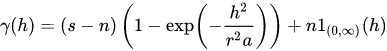

  nugget n: The height of the jump of the semivariogram at the discontinuity at the origin.

  sill s: Limit of the variogram tending to infinity lag distances.
  
  range r: The distance in which the difference of the variogram from the sill becomes negligible. In models with a fixed sill,          it is the distance at which this is first reached; for models with an asymptotic sill, it is conventionally taken to be          the distance when the semivariance first reaches 95% of the sill.
  
  distance h.
  
  ** In this model Sill is 1 and Nugget is 0.
  
  
  

In [9]:
def sample_log_perm(N=1):
    lperms = geostat.gaussian_fields(model.mesh(), N, r=0.3)
    return lperms

The transformation of the parameters to model input is effectively part of the forward model.

In [10]:
def f_perm(x):
    #return .1 + np.exp(5*x)
    return 1000*np.exp(3*x)

In [11]:
def set_perm(model, log_perm_array):
    p = f_perm(log_perm_array)
    p = p.reshape(model.shape)
    model.Gridded.K = np.stack([p, p])                 #assigne value to the grid model of K so simulator can read it.

Here we sample the permeabilitiy of the (synthetic) truth.

In [12]:
perm.Truth = sample_log_perm()
set_perm(model, perm.Truth)


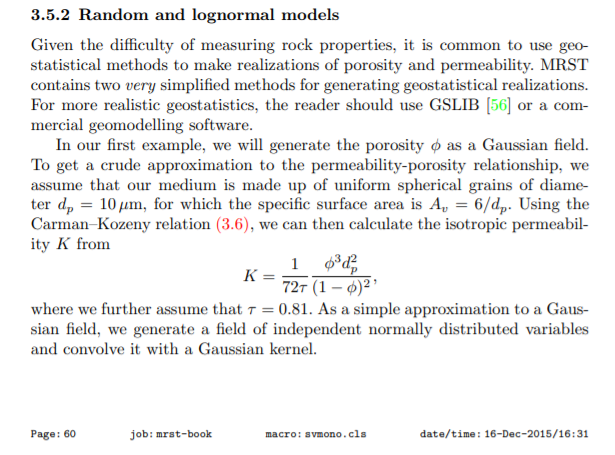
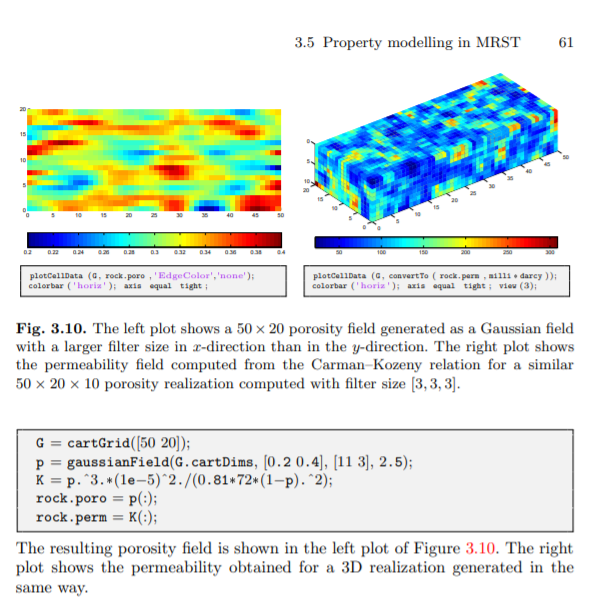

 # Gridded properties
        self.Gridded = DotDict(
            K  =np.ones((2, *self.shape)),  # permeability in x&y dirs.
            por=np.ones(self.shape),        # porosity
        )

#### Well specification
We here specify the wells as point sources and sinks, giving their placement and flux.

The boundary conditions are of the Dirichlet type, specifying zero flux. The source terms must therefore equal the sink terms. This is ensured by the `init_Q` function used below.

Well location is defined in relative-form to reservoir dimentions. It means location (x, y) should be defined as 0< x,y<1

rate should be defined as 0 < rate.

Rate of well will be calculated in fraction of sum of all with same type of well.

In [13]:
### Manual well specification

model.init_Q(
    #     x    y     rate   
    inj =[
        [0.50, 0.50, 2.00],
    ],
    prod=[
        [0.1, 0.10, 1.00],
                 # [0.10, 0.50, 1.00],
        [0.10, 0.90, 1.00],
                # [0.50, 0.10, 1.00],
                # [0.50, 0.50, 1.00],
                 # [0.50, 0.90, 1.00],
        [0.90, 0.10, 1.00],
                # [0.90, 0.50, 1.00],
        [0.90, 0.90, 1.00],
    ]
);

## Wells on a grid
well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid = np.stack(well_grid + [np.ones_like(well_grid[0])])
well_grid = well_grid.T.reshape((-1, 3))
model.init_Q(
    inj =[[0.50, 0.50, 1.00]],
    prod=well_grid,
);

# Random well configuration
# model.init_Q(
#     inj =np.random.rand(1, 3),
#     prod=np.random.rand(8, 3)
# );

In [14]:
well_grid = np.linspace(0.1, .9, 2)
well_grid = np.meshgrid(well_grid, well_grid)
well_grid = np.stack(well_grid + [np.ones_like(well_grid[1])])
well_grid

array([[[0.1, 0.9],
        [0.1, 0.9]],

       [[0.1, 0.1],
        [0.9, 0.9]],

       [[1. , 1. ],
        [1. , 1. ]]])

#### Plot true field

<IPython.core.display.Javascript object>


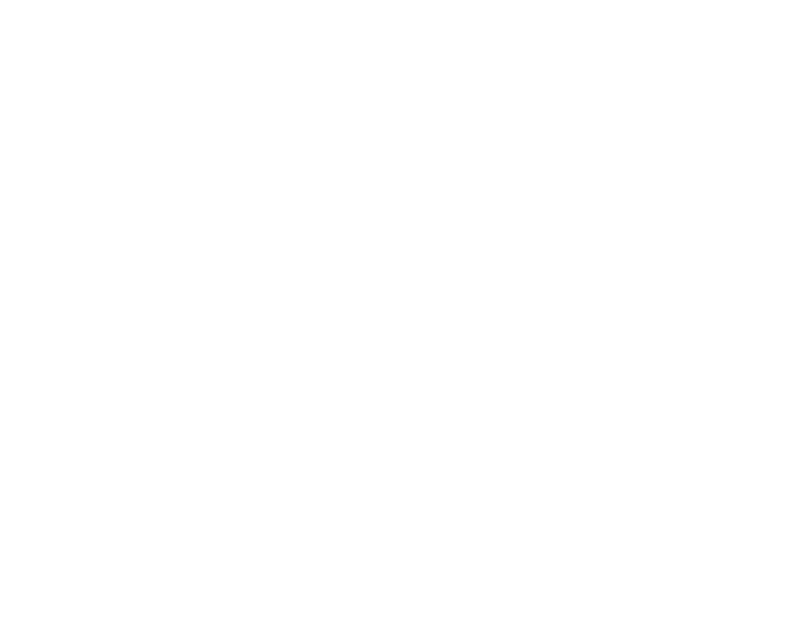

In [15]:
fig, ax = freshfig(110)
# cs = plots.field(model, ax, perm.Truth)
cs = plots.field(model, ax, f_perm(perm.Truth), locator=ticker.LogLocator())
plots.well_scatter(model, ax, model.producers, inj=False)
plots.well_scatter(model, ax, model.injectors, inj=True)
fig.colorbar(cs)
fig.suptitle("True field");
plt.pause(.1)

#### Define obs operator
There is no well model. The data consists purely of the water cut at the location of the wells.

In [16]:
obs_inds = [model.xy2ind(x, y) for (x, y, _) in model.producers]    #Define observation in well cell

def obs(water_sat):
    return [water_sat[i] for i in obs_inds]
obs.length = len(obs_inds)

obs_inds

[11, 18, 81, 88]

#### Simulation to generate the synthetic truth evolution and data

In [17]:
Swi=0                                             #initial water saturation
wsat.initial.Truth = np.zeros(model.M)+Swi

T = 1                                            
dt = 0.2
nTime = round(T/dt)
wsat.past.Truth, prod.past.Truth = simulate(
    model.step, nTime, wsat.initial.Truth, dt, obs)   #obs is function of water sat in location of wells

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
model.step


<bound method ResSim.step of ResSim({
               'Lx': 1,
               'Ly': 1,
               'Nx': 10,
               'Ny': 10,
            'shape': (10, 10),
             'grid': (10, 10, 1, 1),
                'M': 100,
               'hx': 0.1,
               'hy': 0.1,
               'h2': 0.010000000000000002,
          'Gridded': {
                        'K': array([[[5.90392445e+02, 3.65517003e+03, 7.06861205e+04, 7.27904628e+03,
                                      1.70508362e+03, 6.37349594e+03, 2.02039547e+03, 6.96531993e+02,
                                      3.93701376e+02, 5.39344192e+02],
                                     [1.91528037e+01, 6.99598470e+01, 8.57227918e+02, 7.56780235e+02,
                                      2.78785262e+02, 2.14343000e+03, 2.26574041e+04, 1.04711681e+04,
                                      4.83957435e+02, 1.00227460e+03],
                                     [1.82820631e+01, 9.21320226e+00, 3.44461605e+01, 3.12173752e+02,


##### Animation
Run the code cell below to get an animation of the oil saturation evoluation.
Injection (resp. production) wells are marked with triangles pointing down (resp. up).

<mark><font size="-1">
<em>Note:</em> takes a while to load.
</font></mark>

In [19]:
wsat.past.Truth

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.

<IPython.core.display.Javascript object>


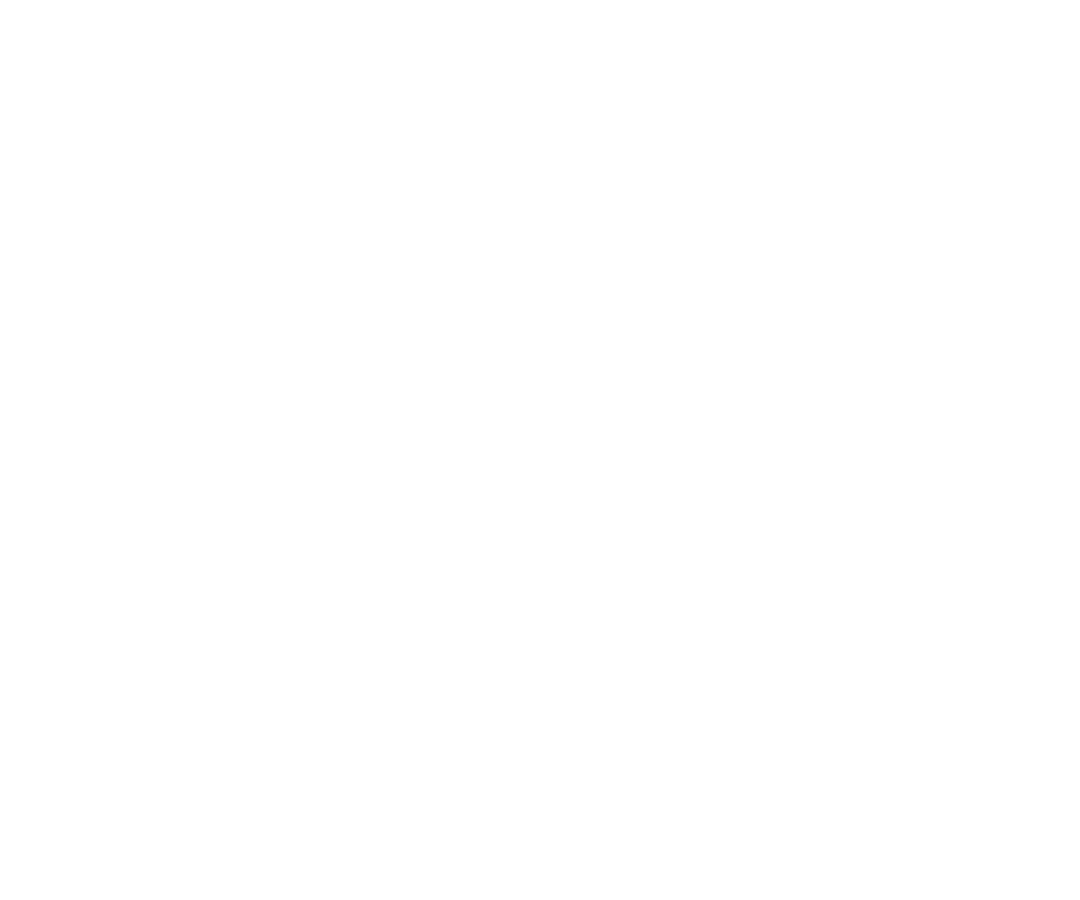

In [20]:
from matplotlib import rc
rc('animation', html="jshtml")
ani = plots.dashboard(model, wsat.past.Truth, prod.past.Truth, animate=True, title="Truth");
ani

#### Noisy obs
In reality, observations are never perfect. To account for this, we corrupt the observations by adding a bit of noise.

In [21]:
model.producers

array([[0.1 , 0.1 , 0.25],
       [0.1 , 0.9 , 0.25],
       [0.9 , 0.1 , 0.25],
       [0.9 , 0.9 , 0.25]])

In [22]:
prod.past.Noisy = prod.past.Truth.copy()
nProd = len(model.producers)  # num. of obs (per time)
R = 1e-3 * np.eye(nProd)
for iT in range(nTime):
    prod.past.Noisy[iT] += sqrt(R) @ randn(nProd)  #random noise

In [23]:
R

array([[0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.001]])

In [24]:
prod.past.Truth.shape

(5, 4)

In [25]:
model.producers

array([[0.1 , 0.1 , 0.25],
       [0.1 , 0.9 , 0.25],
       [0.9 , 0.1 , 0.25],
       [0.9 , 0.9 , 0.25]])

In [26]:
# wsat.past.Noisy = wsat.past.Truth.copy()
# n_wsat = len(model.producers)  # num. of obs (per time)
# R = 1e-3 * np.eye(n_wsat)
# for iT in range(nTime):
#     wsat.past.Noisy[iT] += sqrt(R) @ randn(n_wsat)  #random noise

Plot of observations (and their noise):

<IPython.core.display.Javascript object>


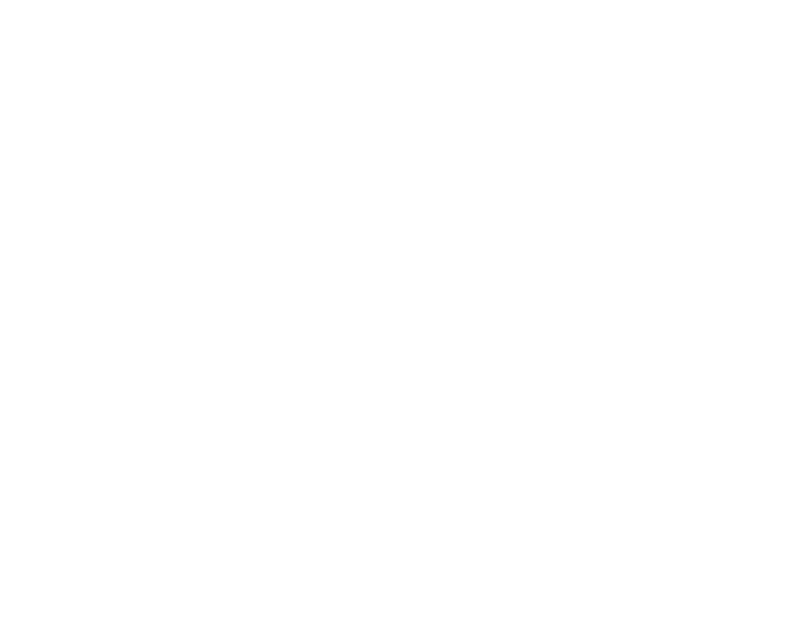

In [27]:
fig, ax = freshfig(122)
hh_y = plots.production1(ax, prod.past.Truth, obs=prod.past.Noisy)
plt.pause(.1)

## Prior
The prior ensemble is generated in the same manner as the (synthetic) truth, using the same mean and covariance.  Thus, the members are "statistically indistinguishable" to the truth. This assumption underlies ensemble methods.

In [28]:
N = 6
perm.Prior = sample_log_perm(N)

In [29]:
# Note that field (before transformation) is Gaussian with (expected) mean 0 and variance 1.
print("Prior mean:", np.mean(perm.Prior))
print("Prior var.:", np.var(perm.Prior))

Prior mean: -0.04208824178060444
Prior var.: 0.7468557325073605


Let us inspect the parameter values in the form of their histogram.

<IPython.core.display.Javascript object>


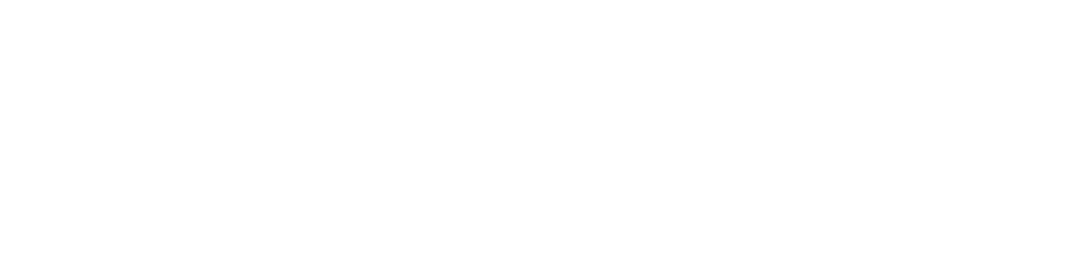

In [30]:
fig, ax = freshfig(130, figsize=(12, 3))
for label, data in perm.items():

    ax.hist(
        f_perm(data.ravel()),
        f_perm(np.linspace(-3, 3, 32)),
        # "Downscale" ens counts by N. Necessary because `density` kw
        # doesnt work "correctly" with log-scale.
        weights = (np.ones(model.M*N)/N if label != "Truth" else None),
        label=label, alpha=0.3)

    ax.set(xscale="log", xlabel="Permeability", ylabel="Count")
    ax.legend();
plt.pause(.1)

The above histogram should be Gaussian histogram if f_perm is purely exponential:

Below we can see some realizations (members) from the ensemble.

<IPython.core.display.Javascript object>


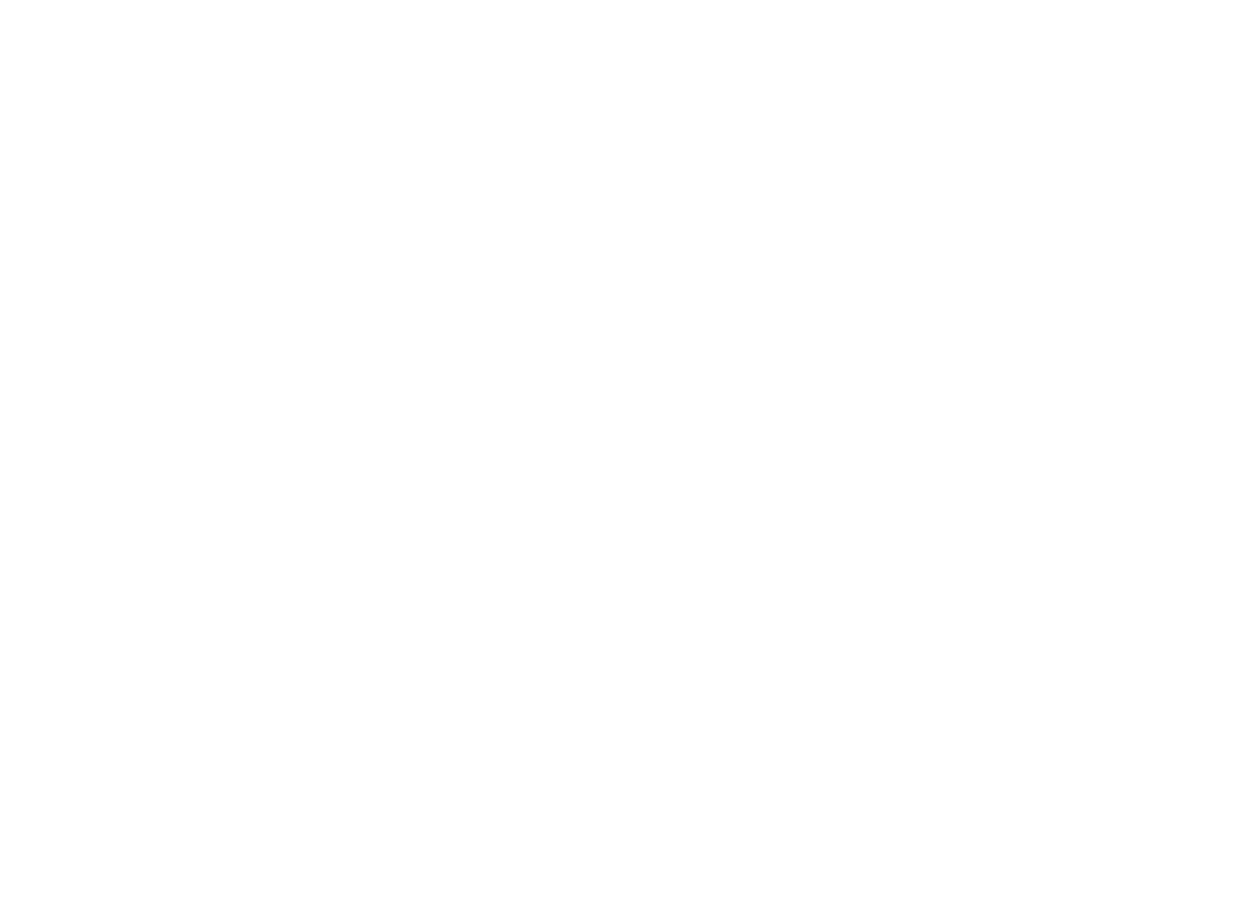

In [31]:
plots.fields(model, 20, plots.field, perm.Prior,
             figsize=(14, 10), cmap=cmap,
             title="Prior -- some realizations");    #max 12 plots of realization

#### Eigenvalue specturm
In practice, of course, we would not be using an explicit `Cov` matrix when generating the prior ensemble, because it would be too large.  However, since this synthetic case in being made that way, let's inspect its spectrum.

<IPython.core.display.Javascript object>


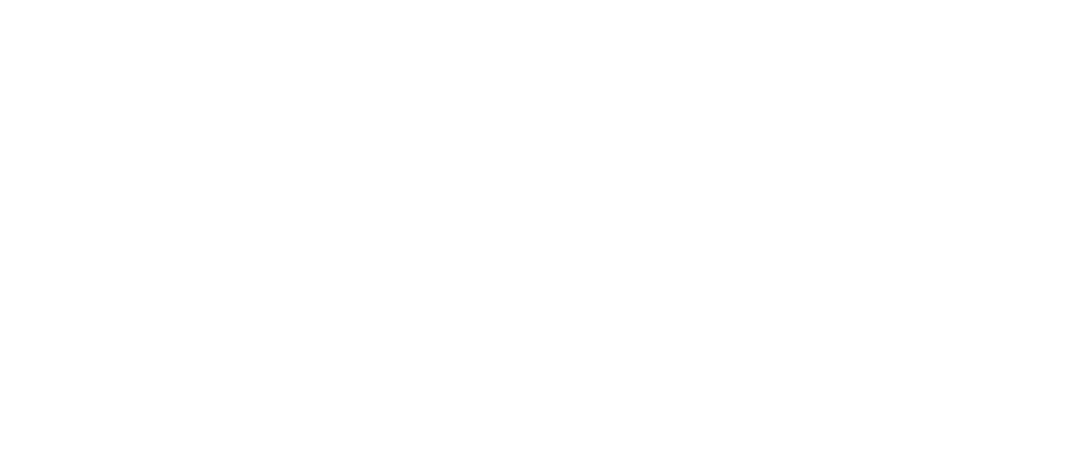

In [32]:
U, svals, VT = sla.svd(perm.Prior)  #Singular value decomposition
ii = 1+np.arange(len(svals))
fig, ax = freshfig(150, figsize=(12, 5))
ax.loglog(ii, svals)
# ax.semilogx(ii, svals)
ax.grid(True, "minor", axis="x")
ax.grid(True, "major", axis="y")
ax.set(xlabel="eigenvalue #", ylabel="var.",
       title="Spectrum of initial, true cov");
plt.pause(.1)

## Assimilation

#### Exc (optional)
Before going into iterative methods, we note that
the ensemble smoother (ES) is favoured over the ensemble Kalman smoother (EnKS) for history matching. This may come as a surprise, because the EnKS processes the observations sequentially, like the ensemble Kalman filter (EnKF), not in the batch manner of the ES. Because sequential processing is more gradual, one would expect it to achieve better accuracy than batch approaches. However, the ES is preferred because the uncertainty in the state fields is often of less importance than the uncertainty in the parameter fields. More imperatively, (re)starting the simulators (e.g. ECLIPSE) from updated state fields (as well as parameter fields) is a troublesome affair; the fields may have become "unphysical" (or "not realisable") because of the ensemble update, which may hinder the simulator from producing meaningful output (it may crash, or have trouble converging). On the other hand, by going back to the parameter fields before geological modelling (using fast model update (FMU)) tends to yield more realistic parameter fields. Finally, since restarts tend to yield convergence issues in the simulator the following inequality is usually large.

$$
\begin{align}
	\max_n \sum_{t}^{} T_t^n < \sum_{t}^{} \max_n T_t^n,
	\label{eqn:max_sum_sum_max}
\end{align}
$$
skjervheim2011ensemble
Here, $T_t^n$

#### Propagation
Ensemble methods obtain observation-parameter sensitivities from the covariances of the ensemble run through the model. Note that this for-loop is "embarrasingly parallelizable", because each iterate is complete indepdendent (requires no communication) from the others.

In [33]:
multiprocess = False  # multiprocessing?

In [34]:
def forecast(nTime, wsats0, perms, Q_prod=None, desc="En. forecast"):
    """Forecast for an ensemble."""
    # Compose ensemble
    if Q_prod is None:
        E = zip(wsats0, perms)            #zip makes tuple
    else:
        E = zip(wsats0, perms, Q_prod)

    def forecast1(x):
        model_n = deepcopy(model)

        if Q_prod is None:
            wsat0, perm = x
            # Set ensemble
            set_perm(model_n, perm)
        else:
            wsat0, perm, q_prod = x
            # Set production rates
            prod = model_n.producers
            prod = well_grid  # model_n.producers uses abs scale
            prod[:, 2] = q_prod
            model_n.init_Q(
                inj = model_n.injectors,
                prod = prod,
            )
            # Set ensemble
            set_perm(model_n, perm)

        # Simulate
        s, p = simulate(model_n.step, nTime, wsat0, dt, obs, pbar=False)
        return s, p

    # Allocate
    production = np.zeros((N, nTime, nProd))
    saturation = np.zeros((N, nTime+1, model.M))

    # Dispatch
    if multiprocess:
        import multiprocessing_on_dill as mpd
        with mpd.Pool() as pool:
            E = list(progbar(pool.imap(forecast1, E), total=N, desc=desc))
        # Write
        for n, member in enumerate(E):
            saturation[n], production[n] = member

    else:
        for n, xn in enumerate(progbar(list(E), "Members")):
            s, p = forecast1(xn)
            # Write
            saturation[n], production[n] = s, p

    return saturation, production

We also need to set the prior for the initial water saturation. As mentioned, this is not because it is uncertain/unknown; indeed, this case study assumes that it is perfectly known (i.e. equal to the true initial water saturation, which is a constant field of 0). However, in order to save one iteration, the posterior will also be output for the present-time water saturation (state) field, which is then used to restart simulations for future prediction (actually, the full time series of the saturation is output, but that is just for academic purposes). Therefore the ensemble forecast function must take water saturation as one of the inputs. Therefore, for the prior, we set this all to the true initial saturation (giving it uncertainty 0).

In [35]:
wsat.initial.Prior = np.tile(wsat.initial.Truth, (N, 1))  #numpy.tile(A, reps)

Now we run the forecast.

In [36]:
wsat.past.Prior, prod.past.Prior = forecast(
    nTime, wsat.initial.Prior, perm.Prior)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
# wsat.past.Prior, prod.past.Prior,perm.past.Prior = forecast(
#     nTime, wsat.initial.Prior, perm.Prior)

In [38]:
perm.Prior.shape

(6, 100)

In [39]:
wsat.past.Prior.shape          #water saturation in reservoir

(6, 6, 100)

In [40]:
prod.past.Noisy.shape

(5, 4)

### Ensemble smoother

In [41]:
class ES_update:
    """Update/conditioning (Bayes' rule) for an ensemble,

    according to the "ensemble smoother" (ES) algorithm,

    given a (vector) observations an an ensemble (matrix).

    NB: obs_err_cov is treated as diagonal. Alternative: use `sla.sqrtm`.

    Why have we chosen to use a class (and not a function)?
    Because this allows storing `KGdY`, which we can then/later re-apply,
    thereby enabling state-augmentation "on-the-fly".

    NB: some of these formulea appear transposed, and reversed,
    compared to (EnKF) literature standards. The reason is that
    we stack the members as rows instead of the conventional columns.
    Rationale: https://nansencenter.github.io/DAPPER/dapper/index.html#conventions
    """

    def __init__(self, obs_ens, observation, obs_err_cov):
        """Prepare the update."""
        Y           = mean0(obs_ens)
        obs_cov     = obs_err_cov*(N-1) + Y.T@Y  #P
        obs_pert    = randn(N, len(observation)) @ sqrt(obs_err_cov)
        innovations = observation - (obs_ens + obs_pert)

        # (pre-) Kalman gain * Innovations
        self.KGdY = innovations @ sla.pinv2(obs_cov) @ Y.T

    def __call__(self, E):
        """Do the update."""
        return E + self.KGdY @ mean0(E)

In [42]:
# #### Update
ES = ES_update(
    obs_ens     = prod.past.Prior.reshape((N, -1)),
    observation = prod.past.Noisy.reshape(-1),
    obs_err_cov = sla.block_diag(*[R]*nTime),          #???????????????????
)

In [43]:
# Apply update
perm.ES = ES(perm.Prior)

#### Plot ES
Let's plot the updated, initial ensemble.

<IPython.core.display.Javascript object>


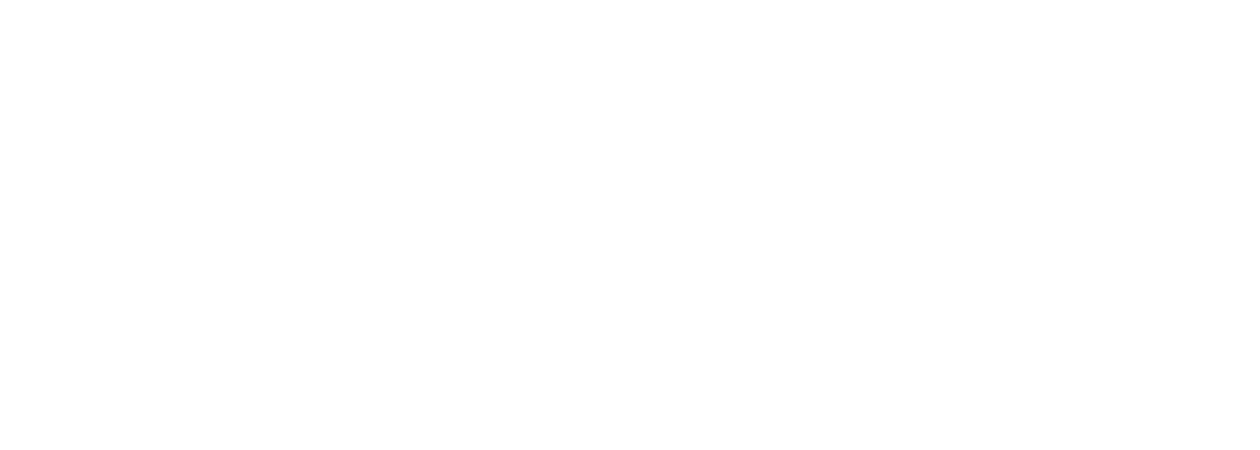

In [44]:
plots.fields(model, 160, plots.field, perm.ES,
             figsize=(14, 5), cmap=cmap,
             title="ES posterior -- some realizations");

We will see some more diagnostics later.

### Iterative ensemble smoother
The following is (almost) all that distinguishes all of the fully-Bayesian iterative ensemble smoothers in the literature.

In [45]:
def iES_flavours(w, T, Y, Y0, dy, Cowp, za, N, nIter, itr, MDA, flavour):
    N1 = N - 1
    Cow1 = Cowp(1.0)

    if MDA:  # View update as annealing (progressive assimilation).
        Cow1 = Cow1 @ T  # apply previous update
        dw = dy @ Y.T @ Cow1
        if 'PertObs' in flavour:   # == "ES-MDA". By Emerick/Reynolds
            D   = mean0(randn(*Y.shape)) * sqrt(nIter)
            T  -= (Y + D) @ Y.T @ Cow1
        elif 'Sqrt' in flavour:    # == "ETKF-ish". By Raanes
            T   = Cowp(0.5) * sqrt(za) @ T
        elif 'Order1' in flavour:  # == "DEnKF-ish". By Emerick
            T  -= 0.5 * Y @ Y.T @ Cow1
        Tinv = np.eye(N)  # [as initialized] coz MDA does not de-condition.

    else:  # View update as Gauss-Newton optimzt. of log-posterior.
        grad  = Y0@dy - w*za                  # Cost function gradient
        dw    = grad@Cow1                     # Gauss-Newton step
        # ETKF-ish". By Bocquet/Sakov.
        if 'Sqrt' in flavour:
            # Sqrt-transforms
            T     = Cowp(0.5) * sqrt(N1)
            Tinv  = Cowp(-.5) / sqrt(N1)
            # Tinv saves time [vs tinv(T)] when Nx<N
        # "EnRML". By Oliver/Chen/Raanes/Evensen/Stordal.
        elif 'PertObs' in flavour:
            if itr == 0:
                D = mean0(randn(*Y.shape))
                iES_flavours.D = D
            else:
                D = iES_flavours.D
            gradT = -(Y+D)@Y0.T + N1*(np.eye(N) - T)
            T     = T + gradT@Cow1
            # Tinv= tinv(T, threshold=N1)  # unstable
            Tinv  = sla.inv(T+1)           # the +1 is for stability.
        # "DEnKF-ish". By Raanes.
        elif 'Order1' in flavour:
            # Included for completeness; does not make much sense.
            gradT = -0.5*Y@Y0.T + N1*(np.eye(N) - T)
            T     = T + gradT@Cow1
            Tinv  = sla.pinv2(T)

    return dw, T, Tinv

This outer function loops through the iterations, forecasting, de/re-composing the ensemble, performing the linear regression, validating step, and making statistics.

In [46]:
def iES(ensemble, observation, obs_err_cov,
        flavour="Sqrt", MDA=False, bundle=False,
        stepsize=1, nIter=10, wtol=1e-4):

    E = ensemble
    N = len(E)
    N1 = N - 1
    Rm12T = np.diag(sqrt(1/np.diag(obs_err_cov)))  # TODO?

    stats = DotDict()
    stats.J_lklhd  = np.full(nIter, np.nan)
    stats.J_prior  = np.full(nIter, np.nan)
    stats.J_postr  = np.full(nIter, np.nan)
    stats.rmse     = np.full(nIter, np.nan)
    stats.stepsize = np.full(nIter, np.nan)
    stats.dw       = np.full(nIter, np.nan)

    if bundle:
        if isinstance(bundle, bool):
            EPS = 1e-4  # Sakov/Boc use T=EPS*eye(N), with EPS=1e-4, but I ...
        else:
            EPS = bundle
    else:
        EPS = 1.0  # ... prefer using  T=EPS*T, yielding a conditional cloud shape

    # Init ensemble decomposition.
    X0, x0 = center(E)    # Decompose ensemble.
    w      = np.zeros(N)  # Control vector for the mean state.
    T      = np.eye(N)    # Anomalies transform matrix.
    Tinv   = np.eye(N)
    # Explicit Tinv [instead of tinv(T)] allows for merging MDA code
    # with iEnKS/EnRML code, and flop savings in 'Sqrt' case.

    for itr in range(nIter):
        # Reconstruct smoothed ensemble.
        E = x0 + (w + EPS*T)@X0
        stats.rmse[itr] = RMS(perm.Truth, E).rmse

        # Forecast.
        E_state, E_obs = forecast(nTime, wsat.initial.Prior, E, desc=f"Iteration {itr}")
        E_obs = E_obs.reshape((N, -1))

        # Undo the bundle scaling of ensemble.
        if EPS != 1.0:
            E     = inflate_ens(E, 1/EPS)
            E_obs = inflate_ens(E_obs, 1/EPS)

        # Prepare analysis.Ç
        y      = observation        # Get current obs.
        Y, xo  = center(E_obs)      # Get obs {anomalies, mean}.
        dy     = (y - xo) @ Rm12T   # Transform obs space.
        Y      = Y        @ Rm12T   # Transform obs space.
        Y0     = Tinv @ Y           # "De-condition" the obs anomalies.

        # Set "cov normlzt fctr" za ("effective ensemble size")
        # => pre_infl^2 = (N-1)/za.
        za = N1
        if MDA:
            # inflation (factor: nIter) of the ObsErrCov.
            za *= nIter

        # Compute Cowp: the (approx) posterior cov. of w
        # (estiamted at this iteration), raised to some power.
        V, s, UT = svd0(Y0)
        def Cowp(expo): return (V * (pad0(s**2, N) + za)**-expo) @ V.T

        # TODO: NB: these stats are only valid for Sqrt
        stat2 = DotDict(
            J_prior = w@w * N1,
            J_lklhd = dy@dy,
        )
        # J_posterior is sum of the other two
        stat2.J_postr = stat2.J_prior + stat2.J_lklhd
        # Take root, insert for [itr]:
        for name in stat2:
            stats[name][itr] = sqrt(stat2[name])

        # Accept previous increment? ...
        if (not MDA) and itr > 0 and stats.J_postr[itr] > np.nanmin(stats.J_postr):
            # ... No. Restore previous ensemble & lower the stepsize (dont compute new increment).
            stepsize   /= 10
            w, T, Tinv  = old  # noqa
        else:
            # ... Yes. Store this ensemble, boost the stepsize, and compute new increment.
            old         = w, T, Tinv
            stepsize   *= 2
            stepsize    = min(1, stepsize)
            dw, T, Tinv = iES_flavours(w, T, Y, Y0, dy, Cowp, za, N, nIter, itr, MDA, flavour)

        stats.      dw[itr] = dw@dw / N
        stats.stepsize[itr] = stepsize

        # Step
        w = w + stepsize*dw

        if stepsize * np.sqrt(dw@dw/N) < wtol:
            break

    stats.nIter = itr + 1

    if not MDA:
        # The last step (dw, T) must be discarded,
        # because it cannot be validated without re-running the model.
        w, T, Tinv  = old

    # Reconstruct the ensemble.
    E = x0 + (w+T)@X0

    return E, stats

#### Apply the iES

In [47]:
perm.iES, stats_iES = iES(
    ensemble = perm.Prior,
    observation = prod.past.Noisy.reshape(-1),
    obs_err_cov = sla.block_diag(*[R]*nTime),
    flavour="Sqrt", MDA=False, bundle=False, stepsize=1,
)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

Members:   0%|          | 0/6 [00:00<?, ?it/s]

#### Plot iES
Let's plot the updated, initial ensemble.

<IPython.core.display.Javascript object>


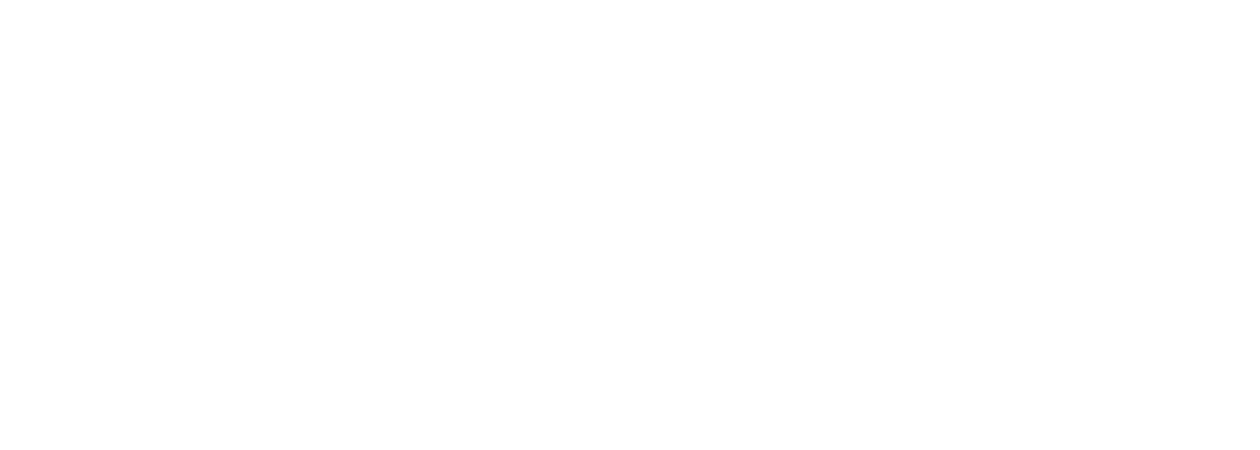

In [48]:
plots.fields(model, 165, plots.field, perm.iES,
             figsize=(14, 5), cmap=cmap,
             title="iES posterior -- some realizations");

The following plots the cost function(s) together with the error compared to the true (pre-)perm field as a function of the iteration number. Note that the relationship between the (total, i.e. posterior) cost function  and the RMSE is not necessarily monotonic. Re-running the experiments with a different seed is instructive. It may be observed that the iterations are not always very successful.

<IPython.core.display.Javascript object>


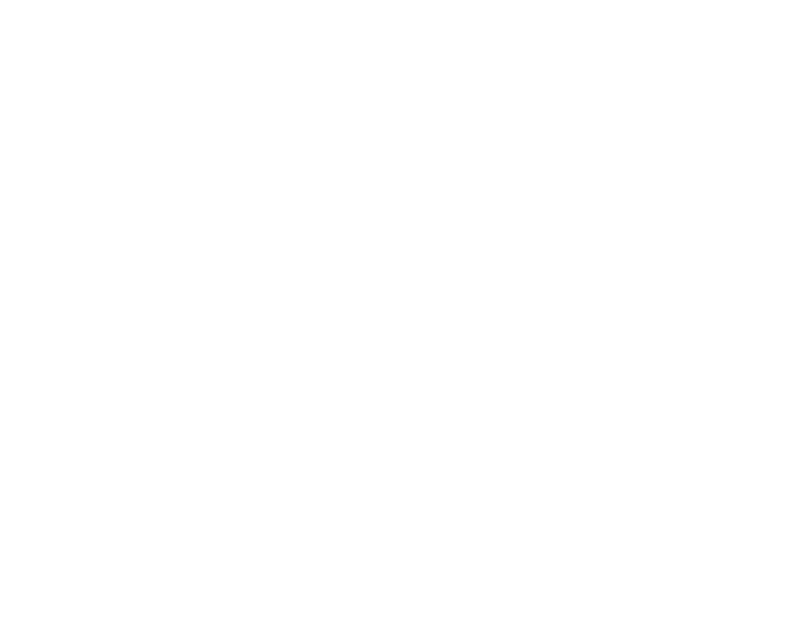

In [49]:
fig, ax = freshfig(167)
ls = dict(J_prior=":", J_lklhd="--", J_postr="-")
for name, J in stats_iES.items():
    try:
        ax.plot(J, color="b", label=name.split("J_")[1], ls=ls[name])
    except IndexError:
        pass
ax.set_xlabel("iteration")
ax.set_ylabel("RMS mismatch", color="b")
ax.tick_params(axis='y', labelcolor="b")
ax.legend()
ax2 = ax.twinx()  # axis for rmse
ax2.set_ylabel('RMS error', color="r")
ax2.plot(stats_iES.rmse, color="r")
ax2.tick_params(axis='y', labelcolor="r")
plt.pause(.1)

### Diagnostics
In terms of root-mean-square error (RMSE), the ES is expected to improve on the prior. The "expectation" wording indicates that this is true on average, but not always. To be specific, it means that it is guaranteed to hold true if the RMSE is calculated for infinitely many experiments (each time simulating a new synthetic truth and observations from the prior). The reason for this is that the ES uses the Kalman update, which is the BLUE (best linear unbiased estimate), and "best" means that the variance must get reduced. However, note that this requires the ensemble to be infinitely big, which it most certainly is not in our case. Therefore, we do not need to be very unlucky to observe that the RMSE has actually increased. Despite this, as we will see later, the data match might yield a different conclusions concerning the utility of the update.

In [50]:
print("Stats vs. true field")
RMS_all(perm, vs="Truth")

Stats vs. true field
Prior   : 1.0635 (rmse),  0.7969 (std)
ES      : 1.7287 (rmse),  0.1325 (std)
iES     : 1.2176 (rmse),  0.0551 (std)


### Plot of means
Let's plot mean fields.

NB: Caution! Mean fields are liable to be less rugged than the truth. As such, their importance must not be overstated (they're just one esitmator out of many). Instead, whenever a decision is to be made, all of the members should be included in the decision-making process.

In [51]:
perm._means = DotDict((k, perm[k].mean(axis=0)) for k in perm
                      if not k.startswith("_"))

<IPython.core.display.Javascript object>


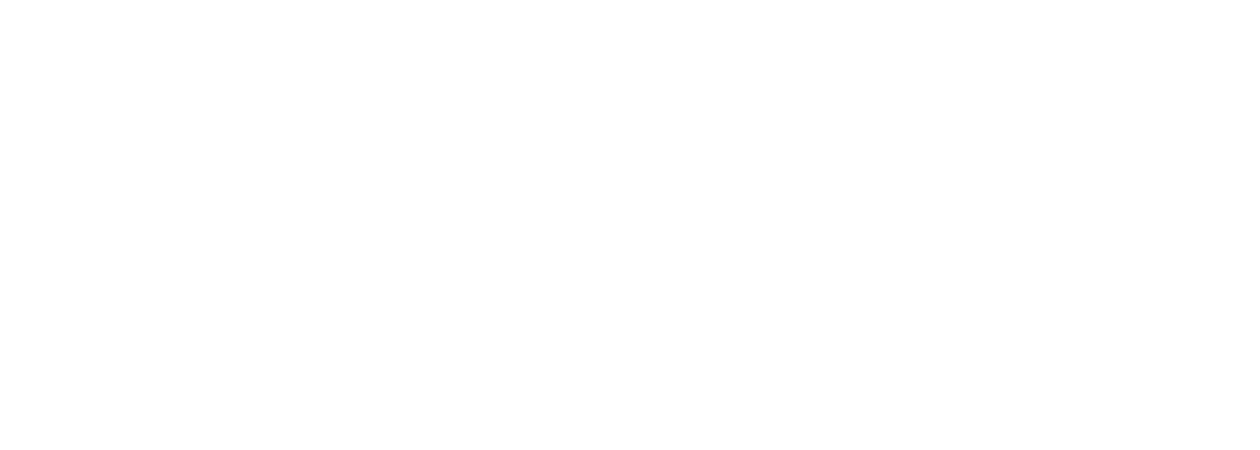

In [52]:
plots.fields(model, 170, plots.field, perm._means,
             figsize=(14, 5), cmap=cmap,
             title="Truth and mean fields.");

### Past production (data mismatch)

We already have the past true and prior production profiles. Let's add to that the production profiles of the posterior.

In [53]:
wsat.past.ES, prod.past.ES = forecast(nTime, wsat.initial.Prior, perm.ES)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
wsat.past.iES, prod.past.iES = forecast(nTime, wsat.initial.Prior, perm.iES)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

We can also apply the ES update (its X5 matrix, for those familiar with that terminology) directly to the production data of the prior, which doesn't require running the model again (like we did immediately above). Let us try that as well.

In [55]:
def ravelled(fun, xx):
    shape = xx.shape
    xx = xx.reshape((shape[0], -1))
    yy = fun(xx)
    return yy.reshape(shape)

In [56]:
prod.past.ES0 = ravelled(ES, prod.past.Prior)

Plot them all together:

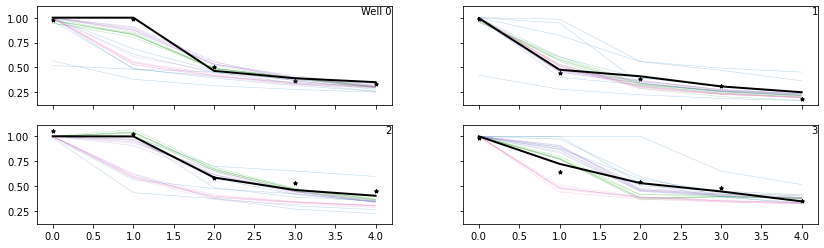

In [57]:
# The notebook/NbAgg backend fails after a few toggles
%matplotlib inline

v = plots.productions(prod.past, 175, figsize=(14, 4))

#### Data mismatch

In [58]:
print("Stats vs. past production (i.e. NOISY observations)")
RMS_all(prod.past, vs="Noisy")

Stats vs. past production (i.e. NOISY observations)
Truth   : 0.2615 (rmse),  0.2635 (std)
Prior   : 0.1582 (rmse),  0.1345 (std)
ES      : 0.1691 (rmse),  0.0117 (std)
iES     : 0.0771 (rmse),  0.0124 (std)
ES0     : 0.0802 (rmse),  0.0136 (std)


Note that the data mismatch is significantly reduced. This may be the case even if the updated permeability field did not have a reduced rmse (overall, relative to that of the prior prior). The "direct" forecast (essentially just linear regression) may achieve even lower rmse, but generally, less realistic production plots.

##### Comment on prior
Note that the prior "surrounds" the data. This the likely situation in our synthetic case, where the truth was generated by the same random draw process as the ensemble.

In practice, this is often not the case. If so, you might want to go back to your geologists and tell them that something is amiss. You should then produce a revised prior with better properties.

Note: the above instructions sound like statistical heresy. We are using the data twice over (on the prior, and later to update/condition the prior). However, this is justified to the extent that prior information is difficult to quantify and encode. Too much prior adaptation, however, and you risk overfitting! Ineed, it is a delicate matter.

##### Comment on posterior
If the assumptions (statistical indistinguishability, Gaussianity) are not too far off, then the ensemble posteriors (ES, EnKS, ES0) should also surround the data, but with a tighter fit.

## Prediction
We now prediction the future production (and saturation fields) by forecasting using the (updated) estimates.

In [59]:
print("Future/prediction")

Future/prediction


In [60]:
wsat.future.Truth, prod.future.Truth = simulate(
    model.step, nTime, wsat.past.Truth[-1], dt, obs)

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

In [61]:
wsat.future.Prior, prod.future.Prior = forecast(
    nTime, wsat.past.Prior[:, -1, :], perm.Prior)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

In [62]:
wsat.future.ES, prod.future.ES = forecast(
    nTime, wsat.past.ES[:, -1, :], perm.ES)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

In [63]:
wsat.future.iES, prod.future.iES = forecast(
    nTime, wsat.past.iES[:, -1, :], perm.iES)

Members:   0%|          | 0/6 [00:00<?, ?it/s]

In [64]:
prod.future.ES0 = ravelled(ES, prod.future.Prior)

#### Plot future production

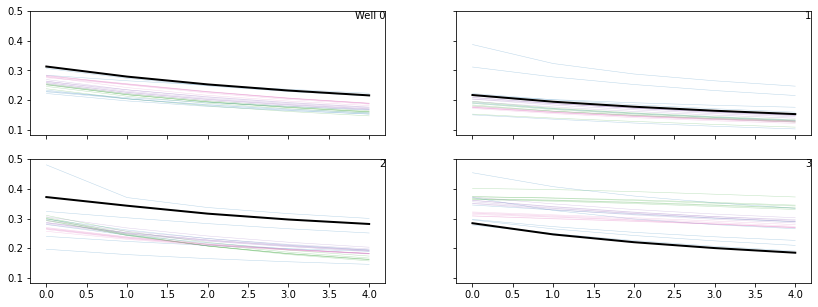

In [65]:
plots.productions(prod.future, 200, figsize=(14, 5), title="-- Future");
plt.pause(.1)

In [66]:
print("Stats vs. (supposedly unknown) future production")
RMS_all(prod.future, vs="Truth")

Stats vs. (supposedly unknown) future production
Prior   : 0.0558 (rmse),  0.0536 (std)
ES      : 0.0667 (rmse),  0.0033 (std)
iES     : 0.0691 (rmse),  0.0054 (std)
ES0     : 0.0915 (rmse),  0.0093 (std)


## EnOpt

This section is still in construction. There are many details missing.

Cost function definition: total oil from production wells. This cost function takes for an ensemble of (wsat, perm) and controls (Q_prod) and outputs the corresponding ensemble of total oil productions.

In [67]:
def total_oil(E, Eu):
    wsat, perm = E
    wsat, prod = forecast(nTime, wsat, perm, Q_prod=Eu)
    return np.sum(prod, axis=(1, 2))

Define step modulator by adding momentum to vanilla gradient descent.

In [68]:
def GDM(beta1=0.9):
    """Gradient descent with (historical) momentum."""
    grad1 = 0

    def set_historical(g):
        nonlocal grad1
        grad1 = beta1*grad1 + (1-beta1)*g

    def step(g):
        set_historical(g)
        return grad1

    return step

Define EnOpt

In [69]:
def EnOpt(wsats0, perms, u, C12, stepsize=1, nIter=10):
    N = len(wsats0)
    E = wsats0, perms

    stepper = GDM()

    print("Initial controls:", u)
#     J = total_oil(E, np.tile(u, (N, 1))).mean()
    print("Total oil, averaged, initial: %.3f" % J)

    for _itr in progbar(range(nIter), desc="EnOpt"):
        Eu = u + randn(N, len(u)) @ C12.T
        Eu = Eu.clip(1e-5)

        Ej = total_oil(E, Eu)
        # print("Approx. total oil, average: %.3f"%Ej.mean())

        Xu = mean0(Eu)
        Xj = mean0(Ej)

        G  = Xj.T @ Xu / (N-1)

        du = stepper(G)
        u  = u + stepsize*du
        u  = u.clip(1e-5)

    print("Final controls:", u)
    J = total_oil(E, np.tile(u, (N, 1))).mean()
    print("Total oil, averaged, final: %.3f" % J)
    return u

In [73]:
u0

array([0.13775663, 0.05032124, 0.47050966, 0.34141247])

In [75]:
Eu = u0 + randn(N, len(u0)) @ C12.T
Eu

array([[0.11952466, 0.04665061, 0.48775976, 0.34871626],
       [0.13772912, 0.08099434, 0.42965518, 0.34640829],
       [0.17284918, 0.06710565, 0.50425057, 0.31362454],
       [0.17213579, 0.0292875 , 0.5044148 , 0.34904037],
       [0.16354972, 0.02689868, 0.46405706, 0.28624972],
       [0.14870389, 0.07280527, 0.48206029, 0.3759125 ]])

In [78]:
randn(N, len(u0))

array([[ 0.63583991,  0.16540858,  0.59313807, -0.50288633],
       [ 0.96889962,  0.32168136,  0.38273163, -0.08660148],
       [-0.526508  , -0.89576411, -0.22236702,  0.77062583],
       [-1.70727397,  0.17992287,  3.61231851,  0.29546206],
       [-0.065268  ,  0.48369355, -0.03441469,  0.21348202],
       [ 0.27243585, -0.86612239,  1.31966051,  0.34064413]])

Run EnOpt

In [70]:
# u0  = model.producers[:, 2]
u0  = np.random.rand(nProd)
u0 /= sum(u0)
C12 = 0.03 * np.eye(nProd)
u   = EnOpt(wsat.past.ES[:, -1, :], perm.ES, u0, C12, stepsize=10)
# u   = EnOpt(wsat.past.iES[:, -1, :], perm.iES, u0, C12, stepsize=10)

Initial controls: [0.13775663 0.05032124 0.47050966 0.34141247]


Members:   0%|          | 0/6 [00:00<?, ?it/s]

IndexError: index 2 is out of bounds for axis 1 with size 2